## Business Problem
One of the global banks would like to understand what factors driving credit card spend are. The bank want use these insights to calculate credit limit. In order to solve the problem, the bank conducted survey of 5000 customers and collected data.



## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [8]:
credit = pd.read_excel("Data Set.xlsx")

In [4]:
credit_x = pd.read_excel("Data Set.xlsx")

In [5]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [26]:
credit.isna().sum()

custid         0
region         0
townsize       2
gender         0
age            0
agecat         0
birthmonth     0
ed             0
edcat          0
jobcat         0
union          0
employ         0
empcat         0
retire         0
income         0
lninc          0
inccat         0
debtinc        0
creddebt       0
lncreddebt     1
othdebt        0
lnothdebt      1
default        0
jobsat         0
marital        0
spoused        0
spousedcat     0
reside         0
pets           0
pets_cats      0
              ..
equipten       0
callcard       0
cardmon        0
cardten        2
wireless       0
wiremon        0
wireten        0
multline       0
voice          0
pager          0
internet       0
callid         0
callwait       0
forward        0
confer         0
ebill          0
owntv          0
hourstv        0
ownvcr         0
owndvd         0
owncd          0
ownpda         0
ownpc          0
ownipod        0
owngame        0
ownfax         0
news           0
response_01   

In [23]:
# Deleting the log form of each feild as it have lots of null value
credit.drop([
 'lntollmon',
 'lntollten',
 'lnequipmon',
 'lnequipten',
 'lncardmon',
 'lncardten',
 'lnwiremon',
 'lnwireten'],axis=1,inplace=True)

In [35]:
credit.isnull().sum().sum()

0

In [33]:
credit['carown'].value_counts()

1.0    3704
0.0     799
Name: carown, dtype: int64

In [32]:
# for these feild -1 has no significance that's why i am replacig it with nan later i will delete it 
credit['carown'].replace(-1,np.nan,inplace= True)
credit['cartype'].replace(-1,np.nan,inplace= True)
credit['carvalue'].replace(-1,np.nan,inplace= True)
credit['carcatvalue'].replace(-1,np.nan,inplace= True)
credit['carbought'].replace(-1,np.nan,inplace= True)

In [29]:
# These 2 variables has no significance 
credit.drop(['custid','birthmonth'],axis=1,inplace = True)

In [30]:
# making the dependent variable
credit['Total']=credit['cardspent']+credit['card2spent']
credit.drop(['cardspent','card2spent'],axis=1,inplace = True)

In [31]:
# replace -1 to 0 as 0 denotes uneducated
credit['spousedcat'].replace(-1,0,inplace=True)
credit['spoused'].replace(-1,0,inplace=True)

In [34]:
credit.dropna(inplace=True)

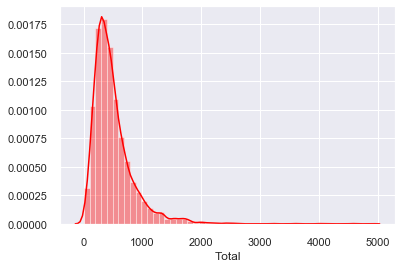

In [36]:
sns.distplot(credit['Total'],color='Red')

In [37]:
credit.shape

(4498, 119)

In [38]:
categorical=['region','townsize','gender','agecat','edcat','jobcat','union','employ','empcat','retire','inccat',
         'default','jobsat','marital','spousedcat','homeown','hometype','address','addresscat','cars','carown','cartype',
         'carcatvalue','carbought','carbuy','commute','commutecat','commutecar','commutemotorcycle','commutecarpool',
         'commutebus','commuterail','commutepublic','commutebike','commutewalk','commutenonmotor','telecommute','reason',
         'polview','polparty','polcontrib','vote','card','cardtype','cardbenefit','cardfee','cardtenure','cardtenurecat',
         'card2','card2type','card2benefit','card2fee','card2tenure','card2tenurecat','active','bfast','churn','tollfree',
         'equip','callcard','wireless','multline','voice','pager','internet','callid','callwait','forward','confer','ebill',
         'owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax','news','response_01','response_02',
         'response_03']


In [39]:
len(categorical)

83

In [40]:
# Numerical List= Contains numerical variables..
numerical=[]
for var in credit.columns:
    if var not in categorical:
        numerical.append(var)

In [41]:
# Creating a seperate dataframe named credit_categorical for categorical variables.
credit_categorical = pd.DataFrame()
for i in credit.columns.values:
      if i in categorical:
        credit_categorical[i]=credit[i]

In [42]:
#creating a seperate dataframe named credit_numerical for numerical variables.
credit_numerical = pd.DataFrame()
for i in credit.columns.values:
      if i in numerical:
        credit_numerical[i]=credit[i]

In [43]:
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df
# Missing value imputation for continuous variables.
def missing_imputation_continuous(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x


In [620]:
credit_numerical.apply(continuous_var_summary).T.round(2)

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,4498.00,0.00,211718.00,47.07,47.00,17.73,314.52,18.00,18.00,20.00,23.00,32.00,47.00,62.00,72.00,76.00,79.00,79.00
ed,4498.00,0.00,65414.00,14.54,14.00,3.23,10.44,8.00,8.00,9.00,10.00,12.00,14.00,17.00,19.00,20.00,21.00,21.00
income,4498.00,0.00,242538.00,53.92,38.00,46.96,2205.06,9.00,9.00,13.00,16.00,24.00,38.00,67.00,111.00,148.00,273.00,273.00
lninc,4498.00,0.00,16641.16,3.70,3.64,0.74,0.55,2.20,2.20,2.56,2.77,3.18,3.64,4.20,4.71,5.00,5.61,5.61
debtinc,4498.00,0.00,44656.87,9.93,8.80,6.26,39.21,0.70,0.70,1.90,2.80,5.10,8.80,13.60,18.70,22.31,29.00,29.01
creddebt,4498.00,0.00,7969.64,1.77,0.93,2.41,5.82,0.03,0.03,0.10,0.17,0.38,0.93,2.07,4.34,6.45,14.35,14.36
lncreddebt,4498.00,0.00,-583.62,-0.13,-0.08,1.25,1.57,-3.42,-3.42,-2.31,-1.75,-0.96,-0.08,0.73,1.47,1.86,2.66,2.66
othdebt,4498.00,0.00,16030.96,3.56,2.09,4.30,18.48,0.11,0.11,0.29,0.45,0.98,2.09,4.37,8.14,12.08,24.24,24.24
lnothdebt,4498.00,0.00,3153.67,0.70,0.74,1.11,1.24,-2.17,-2.17,-1.25,-0.80,-0.02,0.74,1.48,2.10,2.49,3.19,3.19
spoused,4498.00,0.00,29692.00,6.60,0.00,7.21,52.05,0.00,0.00,0.00,0.00,0.00,0.00,14.00,16.00,18.00,20.00,20.00


In [44]:
credit_categorical.shape

(4498, 83)

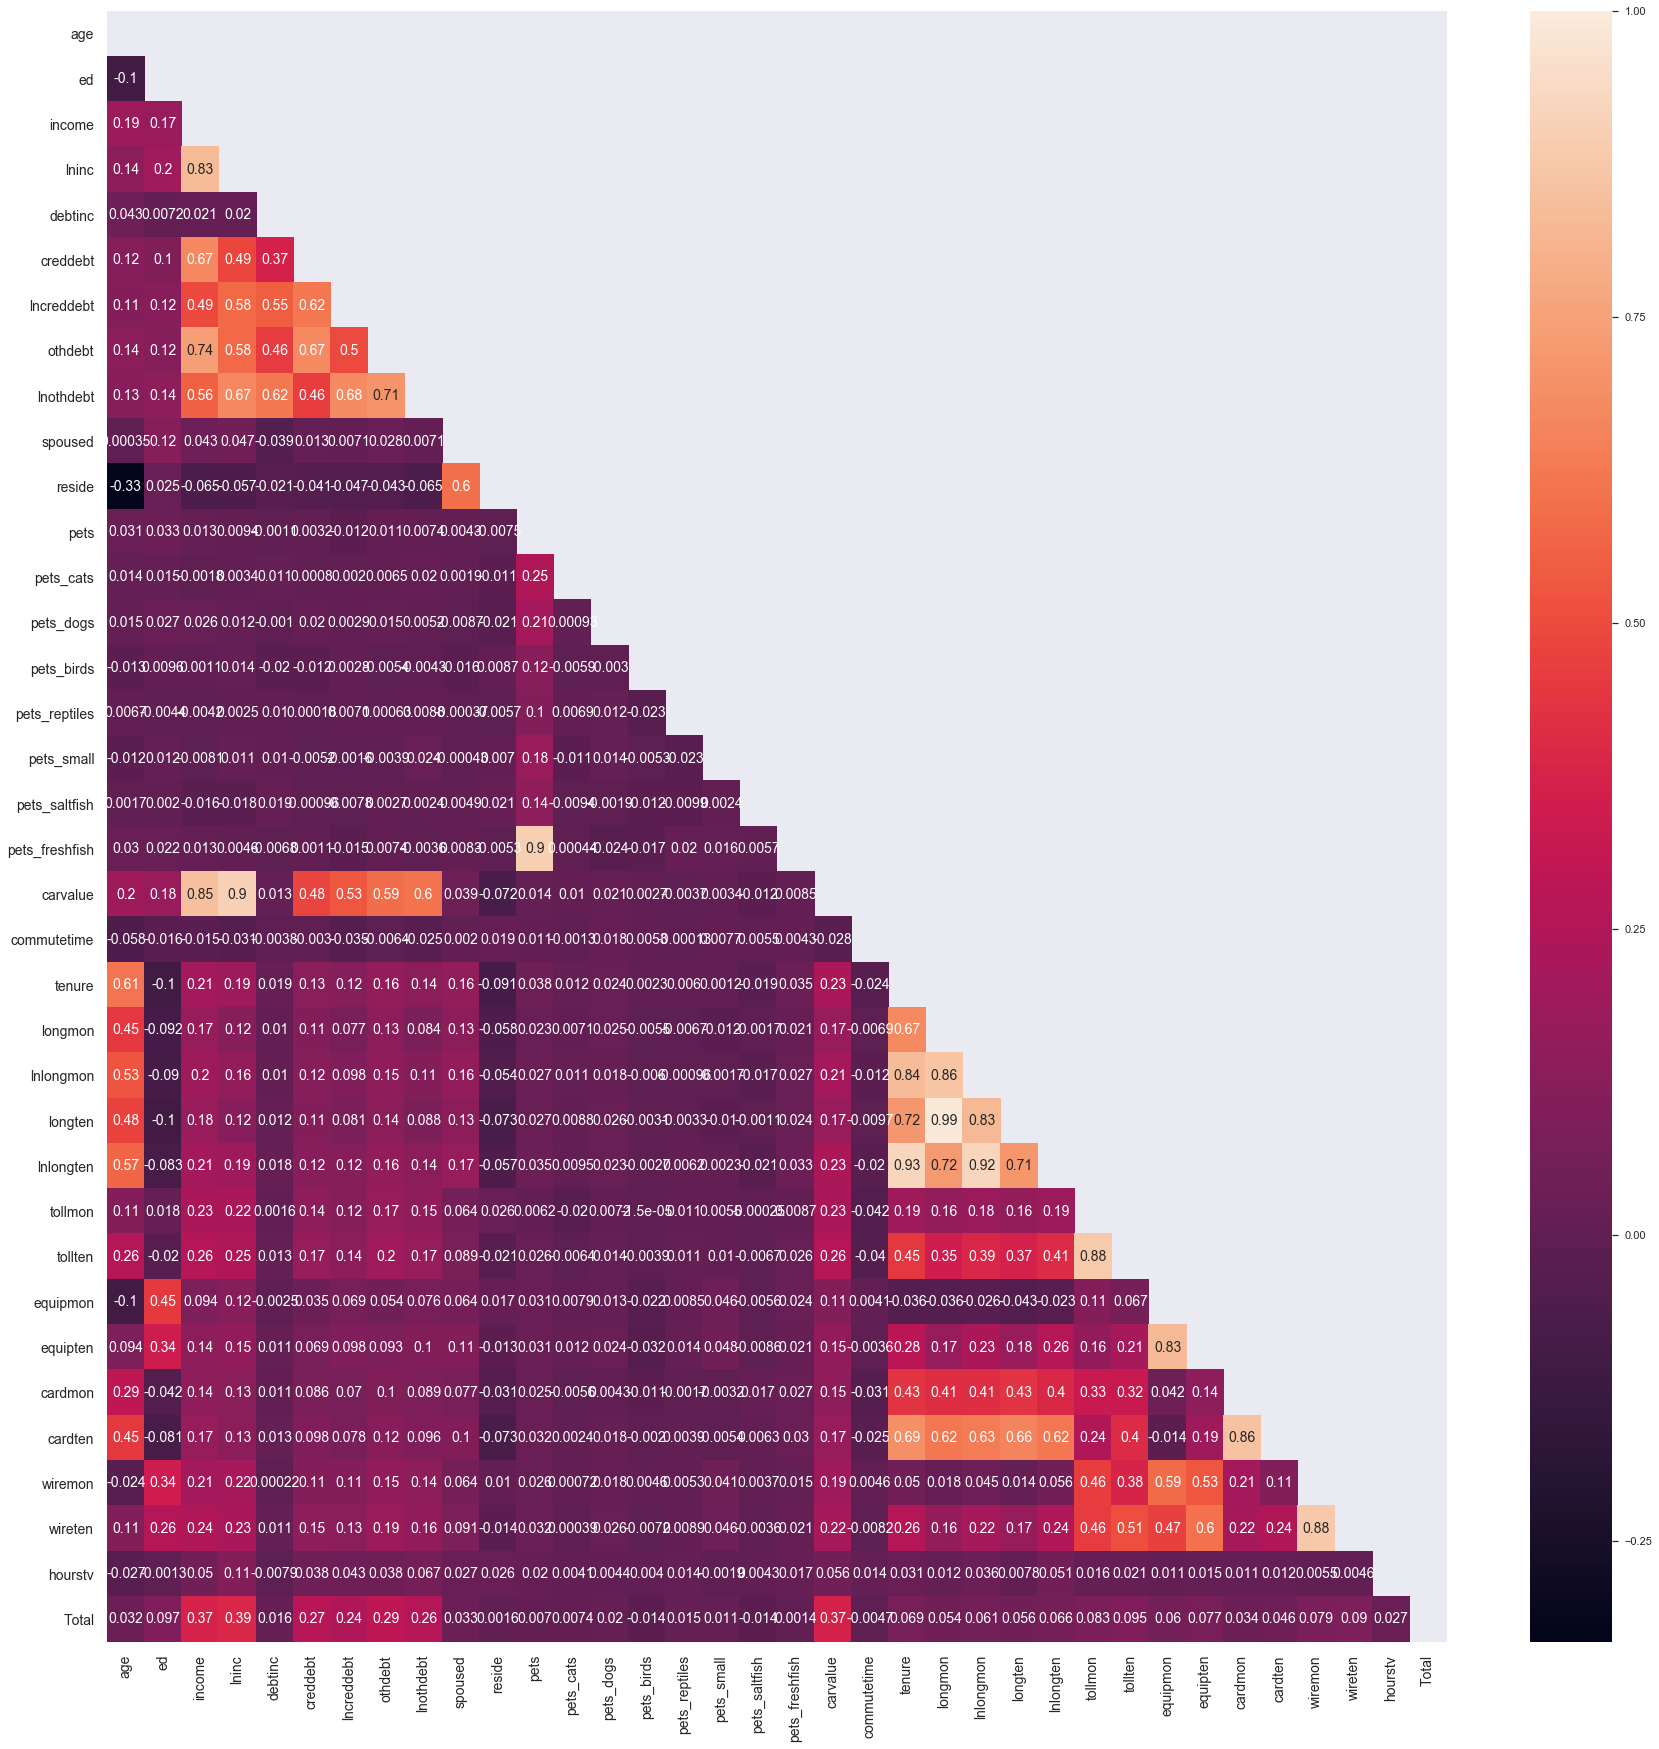

In [45]:
mask = np.zeros_like(credit_numerical.corr())
triangle_indices = np.triu_indices_from(mask)
mask[triangle_indices] = True

plt.figure(figsize=(30,30))
sns.heatmap(credit_numerical.corr(), mask=mask, annot=True, annot_kws={"size": 14})
sns.set_style('white')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [46]:
variables = credit_numerical[credit_numerical.columns.difference(['Total'])]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

C:\Users\acer\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,features
0,14.885371,age
1,13.169617,cardmon
2,15.334823,cardten
3,15.981222,carvalue
4,18.533302,commutetime
5,4.258147,creddebt
6,12.952585,debtinc
7,26.463178,ed
8,10.209373,equipmon
9,9.052453,equipten


In [47]:
credit_numerical
credit_numerical = credit_numerical.apply(lambda x: x.clip(lower = x.dropna().quantile(0.01), upper = x.quantile(0.99)))

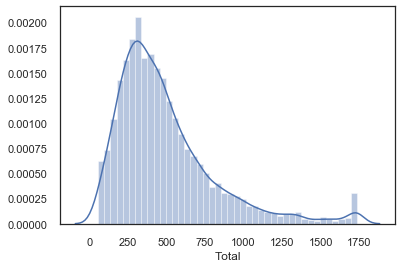

In [48]:
sns.distplot(credit_numerical['Total'])

In [49]:
credit_categorical['townsize'].astype('int')

0       2
1       5
2       4
3       3
4       2
6       5
7       4
8       3
9       2
10      1
11      4
12      2
14      1
15      1
16      1
17      2
19      1
20      3
21      4
22      1
24      3
25      3
26      4
28      1
29      3
30      5
31      2
33      1
35      5
36      1
       ..
4967    3
4968    1
4971    5
4972    1
4973    5
4974    3
4975    4
4976    1
4977    5
4978    1
4979    1
4980    1
4981    1
4982    3
4983    2
4984    3
4985    2
4986    1
4987    4
4988    2
4989    2
4990    3
4991    2
4993    3
4994    1
4995    2
4996    3
4997    5
4998    1
4999    5
Name: townsize, Length: 4498, dtype: int32

In [50]:
def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [51]:
# df_dummy =credit_categorical
# df_dummy
for dm in categorical:
    credit_categorical = create_dummies(credit_categorical,dm)



In [52]:
credit_categorical.shape

(4498, 338)

In [53]:
credit_new = pd.concat([credit_numerical, credit_categorical], axis = 1)

In [55]:
credit_new['total_log']=np.log(credit['Total'])

In [56]:
credit_new.drop('Total',axis=1,inplace= True)

In [57]:
credit_new.shape

(4498, 374)

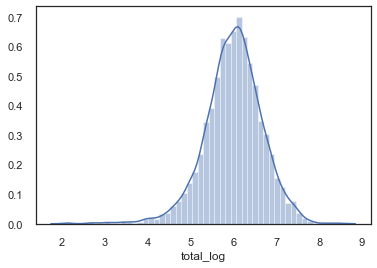

In [58]:
sns.distplot(credit_new['total_log'])

## Feature selection 

In [60]:
variables = credit_new[credit_new.columns.difference(['total_log'])]

vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif["features"] = variables.columns
vif

,VIF,features
0,2.262269,active_1
1,2.568860,address_1
2,inf,address_10
3,inf,address_11
4,inf,address_12
5,inf,address_13
6,inf,address_14
7,inf,address_15
8,inf,address_16
9,inf,address_17


In [108]:
credit_analysis=credit_new.drop(list(vif[vif['VIF']>12]['features']),axis=1,inplace = False)

In [109]:
credit_analysis.shape
#credit_analysis['total_log']=np.log(credit['Total'])

(4498, 130)

In [110]:
x1 = credit_analysis.drop('total_log',axis=1)
y1 = credit_analysis['total_log']

In [111]:
train_x,test_x,train_y,test_y=train_test_split(x1,
                                               y1,test_size=0.3,
                                              random_state=12)

In [112]:
import statsmodels.api as sm
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
smlr = sm.OLS(train_y, train_x).fit()

In [113]:
smlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_log   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     11.75
Date:                Fri, 27 Mar 2020   Prob (F-statistic):          2.29e-183
Time:                        01:28:16   Log-Likelihood:                -2596.5
No. Observations:                3148   AIC:                             5453.
Df Residuals:                    3018   BIC:                             6240.
Df Model:                         129                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   6.5084      0.102     63.838      0.000       6.309       6.708
creddebt                0.0098      0.008      1.249      0.212      -0.006       0.025
lncreddebt              0.0017      0.016      0.107      0.915      -0.029       0.032
othdebt                 0.0065      0.005      1.365      0.172      -0.003       0.016
lnothdebt               0.0146      0.020      0.744      0.457      -0.024       0.053
reside                  0.0042      0.008      0.515      0.606      -0.012       0.020
pets_cats              -0.0165      0.012     -1.330      0.184      -0.041       0.008
pets_dogs              -0.0144      0.013     -1.070      0.285      -0.041       0.012
pets_birds             -0.0343      0.022     -1.593      0.111      -0.077       0.008
pets_reptiles           0.0210      0.038      0.554      0.580      -0.053       0.095
pets_small             -0.0034      0.021     -0.160      0.873      -0.045       0.038
pets_saltfish           0.0221      0.047      0.475      0.635      -0.069       0.113
equipten             1.228e-05   1.48e-05      0.831      0.406   -1.67e-05    4.13e-05
region_2                0.0424      0.033      1.297      0.195      -0.022       0.106
region_3                0.0068      0.033      0.203      0.839      -0.059       0.072
region_4                0.0037      0.034      0.109      0.913      -0.062       0.069
region_5                0.0587      0.035      1.662      0.097      -0.011       0.128
townsize_2.0           -0.0116      0.030     -0.384      0.701      -0.071       0.048
townsize_3.0           -0.0048      0.032     -0.148      0.883      -0.068       0.059
townsize_4.0            0.0058      0.034      0.172      0.863      -0.060       0.072
townsize_5.0            0.0369      0.039      0.953      0.341      -0.039       0.113
gender_1               -0.0378      0.021     -1.827      0.068      -0.078       0.003
agecat_3               -0.0105      0.030     -0.351      0.726      -0.069       0.048
edcat_2                -0.0218      0.023     -0.958      0.338      -0.066       0.023
jobcat_2               -0.0249      0.027     -0.915      0.360      -0.078       0.028
jobcat_3                0.0127      0.035      0.360      0.719      -0.056       0.082
jobcat_4               -0.0488      0.054     -0.904      0.366      -0.155       0.057
jobcat_5               -0.0379      0.040     -0.945      0.345      -0.117       0.041
jobcat_6               -0.0250      0.035     -0.717      0.473      -0.094       0.043
union_1                 0.0028      0.029      0.097      0.923      -0.054       0.060
employ_1               -0.0871      0.040     -2.172      0.030      -0.166      -0.008
retire_1               -0.1909      0.039     -4.929      0.000      -0.267      -0.115
inc

In [118]:
abc=pd.DataFrame({'coef': smlr.params, 'p-value': round(smlr.pvalues, 3)})
abc.shape
credit_analysisxxx=credit_analysis.drop(['total_log'],axis=1)
ef=abc[1:]
ef['feature']=credit_analysisxxx.columns
ef.sort_values(by=['p-value'])
# ef.shape
# credit_analysis3['retire']=credit[['retire']]
# credit_analysis3['income']=credit_x[['lninc']]
#,'feature': credit_analysis.columns   total_log

C:\Users\acer\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,coef,p-value,feature
card_3,-0.594139,0.000,card_3
card_5,-0.496303,0.000,card_5
card2_2,-0.378360,0.000,card2_2
card_2,-0.559714,0.000,card_2
card2_3,-0.389259,0.000,card2_3
card2_4,-0.462318,0.000,card2_4
card2_5,-0.280902,0.000,card2_5
carcatvalue_2,0.117734,0.000,carcatvalue_2
card_4,-0.698489,0.000,card_4
carcatvalue_3,0.408969,0.000,carcatvalue_3


In [115]:
ef.shape

(129, 3)

Removing Variables one by one

In [578]:
#credit_analysis2 = credit_analysis.drop(list(ef[ef['p-value']>0.09]['feature']),axis=1)
#credit_analysis2['retire']=credit[['retire']]
#credit_analysis2['income']=credit_x[['lninc']]

credit_analysis2 = credit_analysis.drop(['commutemotorcycle_1','address_2','cars_8','cardtype_3','commutecarpool_1',
                                        'cardfee_1','card2benefit_4','union_1','region_4','lncreddebt',
                                        'callid_1','cars_3','townsize_3.0','ownfax_1','pets_small',
                                        'region_3','pager_1','polparty_1','jobsat_5','hometype_3',
                                        'jobsat_3','hometype_2','telecommute_1','confer_1','callcard_1',
                                        'forward_1','polview_5','hometype_4','townsize_4.0','commute_2',
                                        'cardbenefit_4','response_01_1','cardbenefit_2','agecat_3','jobcat_3',
                                        'multline_1','commutecar_1','internet_4','homeown_1','cars_4',
                                        'cars_7','reason_3','cartype_1','owngame_1','pets_saltfish',
                                        'churn_1','townsize_2.0','commutepublic_1','inccat_4','cardtype_2',
                                        'cardtype_4','reside','card2fee_1','commutewalk_1','pets_reptiles',
                                        'commutebus_1','cardbenefit_3','news_1','polview_6','card2type_4',
                                        'bfast_2','jobcat_6','jobcat_4','jobcat_2','jobcat_5',
                                        'equipten','internet_3','polview_7','polcontrib_1','carbought_1',
                                        'default_1','jobsat_2','card2type_3','card2type_2','edcat_2',
                                        'pets_dogs','cars_5','ebill_1','ownipod_1','card2benefit_2',
                                        'vote_1','ownpda_1','lnothdebt','cars_2','active_1',
                                        'address_1','cars_6','commutenonmotor_1','townsize_5.0','polview_3',
                                        'bfast_3','commuterail_1','region_2','pets_cats','card2benefit_3',
                                        'internet_2','pets_birds','carbuy_1','commutebike_1','creddebt',
                                        'jobsat_4','ownpc_1','internet_1','response_03_1','response_02_1',
                                        'voice_1','callwait_1','region_5','reason_4','gender_1',
                                        'carown_1.0','polview_2','employ_1','inccat_2','inccat_3'],axis=1)

In [579]:
x1 = credit_analysis2.drop('total_log',axis=1)
y1 = credit_analysis2['total_log']

In [580]:
train_x,test_x,train_y,test_y=train_test_split(x1,
                                               y1,test_size=0.3,
                                              random_state=12)

In [581]:
train_x = sm.add_constant(train_x)
test_x = sm.add_constant(test_x)
smlr2 = sm.OLS(train_y, train_x).fit()

smlr2.summary()

C:\Users\acer\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              total_log   R-squared:                       0.308
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                     99.57
Date:                Fri, 27 Mar 2020   Prob (F-statistic):          7.13e-238
Time:                        02:20:36   Log-Likelihood:                -2657.7
No. Observations:                3148   AIC:                             5345.
Df Residuals:                    3133   BIC:                             5436.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             6.5751      0.050    132.681      0.000       6.478       6.672
othdebt           0.0116      0.003      3.985      0.000       0.006       0.017
retire_1         -0.2406      0.030     -8.143      0.000      -0.298      -0.183
carcatvalue_2     0.1975      0.025      7.879      0.000       0.148       0.247
carcatvalue_3     0.4482      0.034     13.065      0.000       0.381       0.515
reason_2          0.3938      0.049      8.100      0.000       0.299       0.489
reason_9          0.1187      0.031      3.867      0.000       0.058       0.179
card_2           -0.5750      0.033    -17.638      0.000      -0.639      -0.511
card_3           -0.6067      0.033    -18.525      0.000      -0.671      -0.543
card_4           -0.7079      0.034    -20.990      0.000      -0.774      -0.642
card_5           -0.5243      0.054     -9.665      0.000      -0.631      -0.418
card2_2          -0.3911      0.033    -11.886      0.000      -0.456      -0.327
card2_3          -0.4049      0.033    -12.334      0.000      -0.469      -0.341
card2_4          -0.4749      0.036    -13.155      0.000      -0.546      -0.404
card2_5          -0.2955      0.047     -6.225      0.000      -0.389      -0.202
==============================================================================
Omnibus:                      342.899   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              757.517
Skew:                          -0.663   Prob(JB):                    3.22e-165
Kurtosis:                       5.005   Cond. No.                         44.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [582]:
train_x.shape

(3148, 15)

In [584]:
pd.DataFrame({'coef': smlr2.params, 'p-value': round(smlr2.pvalues,4)}).sort_values(by=["p-value"],ascending=False)

,coef,p-value
othdebt,0.011608,0.0001
reason_9,0.118652,0.0001
const,6.575068,0.0000
retire_1,-0.240570,0.0000
carcatvalue_2,0.197528,0.0000
carcatvalue_3,0.448158,0.0000
reason_2,0.393832,0.0000
card_2,-0.575005,0.0000
card_3,-0.606730,0.0000
card_4,-0.707862,0.0000


## Apply Linear Regression

In [598]:
reg = LinearRegression()

In [599]:
reg.fit(train_x,train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [600]:
y_hat = reg.predict(train_x)

In [601]:
y_hat

array([6.33464503, 6.20036265, 6.16326315, ..., 5.72188143, 5.77957897,
       6.05358715])

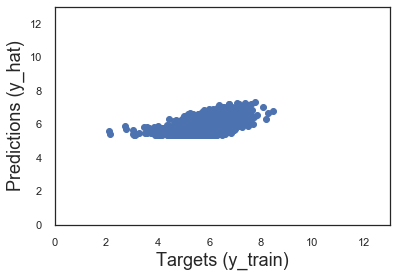

In [602]:
# The simplest way to compare the targets (y_train) and the predictions (y_hat) is to plot them on a scatter plot
# The closer the points to the 45-degree line, the better the prediction
plt.scatter(train_y, y_hat)
# Let's also name the axes
plt.xlabel('Targets (y_train)',size=18)
plt.ylabel('Predictions (y_hat)',size=18)
# Sometimes the plot will have different scales of the x-axis and the y-axis
# This is an issue as we won't be able to interpret the '45-degree line'
# We want the x-axis and the y-axis to be the same
plt.xlim(0,13)
plt.ylim(0,13)
plt.show()

In [603]:
reg.score(test_x,test_y)

0.29450807663335477

Text(0.5, 1.0, 'Residuals PDF')

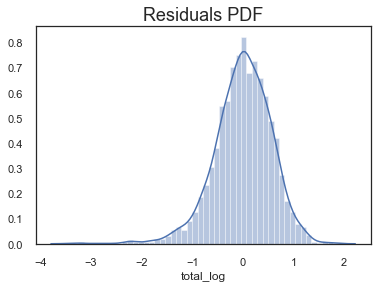

In [604]:
sns.distplot(train_y - y_hat)

# Include a title
plt.title("Residuals PDF", size=18)

In [605]:
y_hat_test = reg.predict(test_x)

In [606]:
test_x.shape

(1350, 15)

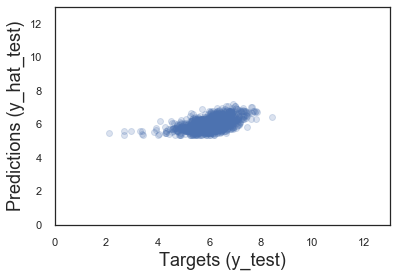

In [607]:
# Create a scatter plot with the test targets and the test predictions
# You can include the argument 'alpha' which will introduce opacity to the graph
plt.scatter(test_y, y_hat_test, alpha=0.2)
plt.xlabel('Targets (y_test)',size=18)
plt.ylabel('Predictions (y_hat_test)',size=18)
plt.xlim(0,13)
plt.ylim(0,13)
plt.show()

In [608]:
df_pf = pd.DataFrame(np.exp(y_hat_test), columns=['Prediction'])
df_pf.head()

,Prediction
0,427.548812
1,294.965962
2,388.499777
3,296.381777
4,466.004012


In [609]:
# We can also include the test targets in that data frame (so we can manually compare them)
df_pf['Target'] = np.exp(test_y)
df_pf

,Prediction,Target
0,427.548812,NaN
1,294.965962,NaN
2,388.499777,NaN
3,296.381777,359.41
4,466.004012,507.83
5,313.355783,NaN
6,632.955032,952.46
7,208.626523,NaN
8,301.087444,NaN
9,297.795361,NaN


In [610]:
test_y = test_y.reset_index(drop=True)

In [611]:
test_y.head()

0    5.470546
1    6.561568
2    5.840990
3    5.820083
4    6.410076
Name: total_log, dtype: float64

In [612]:
df_pf['Target'] = np.exp(test_y)
df_pf

,Prediction,Target
0,427.548812,237.59
1,294.965962,707.38
2,388.499777,344.12
3,296.381777,337.00
4,466.004012,607.94
5,313.355783,50.17
6,632.955032,442.19
7,208.626523,187.67
8,301.087444,137.96
9,297.795361,710.83


In [613]:
# Additionally, we can calculate the difference between the targets and the predictions
# Note that this is actually the residual (we already plotted the residuals)
df_pf['Residual'] = df_pf['Target'] - df_pf['Prediction']

In [614]:
df_pf['Difference%'] = np.absolute(df_pf['Residual']/df_pf['Target']*100)
df_pf

,Prediction,Target,Residual,Difference%
0,427.548812,237.59,-189.958812,79.952360
1,294.965962,707.38,412.414038,58.301625
2,388.499777,344.12,-44.379777,12.896599
3,296.381777,337.00,40.618223,12.052885
4,466.004012,607.94,141.935988,23.347039
5,313.355783,50.17,-263.185783,524.587967
6,632.955032,442.19,-190.765032,43.140965
7,208.626523,187.67,-20.956523,11.166688
8,301.087444,137.96,-163.127444,118.242566
9,297.795361,710.83,413.034639,58.105966


In [615]:
df_pf.describe()

,Prediction,Target,Residual,Difference%
count,1350.000000,1350.000000,1350.000000,1350.000000
mean,433.350591,499.528363,66.177772,52.351336
std,175.689701,351.984712,295.062502,121.270834
min,206.842108,8.110000,-706.435109,0.010197
25%,301.532647,285.402500,-106.677581,15.312026
50%,389.348159,414.005000,12.428714,32.574359
75%,516.768057,609.032500,180.928194,54.046917
max,1381.626322,4572.500000,3966.392628,2890.811479


### Checking Linear Regression Model Accuracy

In [616]:
pd.options.display.max_rows = 999
# Moreover, to make the dataset clear, we can display the result with only 2 digits after the dot 
pd.set_option('display.float_format', lambda x: '%.2f' % x)
# Finally, we sort by difference in % and manually check the model
final_file=df_pf.sort_values(by=['Difference%'])

In [617]:
print('MSE Test:',metrics.mean_squared_error(test_y,y_hat_test))
print('MSE Train:',metrics.mean_squared_error(train_y,y_hat))

MSE Test: 0.30819877526561257
MSE Train: 0.3183542466419542


In [618]:
print ('MAE:', metrics.mean_absolute_error(test_y, y_hat_test))
print ('MSE:', metrics.mean_squared_error(test_y, y_hat_test))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, y_hat_test)))

MAE: 0.42037823916647843
MSE: 0.30819877526561257
RMSE: 0.5551565322191684


In [621]:
final_file.to_csv('Test_results.csv',index=False)